In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
GRID_SIZE = 5
START_STATE = (0, 0)
FOOD_STATE = (4, 4)
ACTIONS = [(0, -1), (0, 1), (-1, 0), (1, 0)]
FORBIDDEN_FURNITURES = [(2, 1), (2, 2), (2, 3), (3, 2)]
MONSTERS = [(0, 3), (4, 1)]
GAMMA = 0.925
MAX_ITERATIONS = 10000
ALPHA=0.005
EPSILON=0.1
RUNS=20

In [3]:
value_iteration_v = np.array([
    [2.6638, 2.9969, 2.8117, 3.6671, 4.8497],
    [2.9713, 3.5101, 4.0819, 4.8497, 7.1648],
    [2.5936, 0.0,    0.0,    0.0,    8.4687],
    [2.0992, 1.0849, 0.0,    8.6097, 9.5269],
    [1.0849, 4.9465, 8.4687, 9.5269, 0.0]
])

In [4]:
policy_mat = [
    [(0, 1), (1, 0), (0, -1), (1, 0), (1, 0)],
    [(0, 1), (0, 1), (0, 1), (0, 1), (1, 0)],   
    [(-1, 0), None, None, None, (1, 0)],
    [(-1, 0), (0, -1), None, (0, 1), (1, 0)],
    [(-1, 0), (0, 1), (0, 1), (0, 1), None]
]

In [5]:
def is_valid_state(i, j):
    if i < 0 or j < 0 or i >= GRID_SIZE or j >= GRID_SIZE:
        return False
    if (i, j) in FORBIDDEN_FURNITURES:
        return False
    return True

In [6]:
def initialize_q_and_policy():
    q = {state: {a: 0 for a in ACTIONS} for state in 
         [(i, j) for i in range(GRID_SIZE) for j in range(GRID_SIZE) if is_valid_state(i, j)]}
    policy = {state: {a: 1 / len(ACTIONS) for a in ACTIONS} for state in q.keys()}
    return q, policy 

In [7]:
def random_initial_state():
    while True:
        state = (np.random.randint(GRID_SIZE), np.random.randint(GRID_SIZE))
        if is_valid_state(*state):
            return state

In [8]:
def getReward(state):
    if state == FOOD_STATE:
        return 10
    elif state in MONSTERS:
        return -8
    else:
        return -0.05

In [9]:
def getTransitionProbabilities(action, p):
    if action == (0, -1):
        specified = (0, -1)
        left = (1, 0)
        right = (-1, 0)
    elif action == (0, 1):
        specified = (0, 1)
        left = (-1, 0)
        right = (1, 0)
    elif action == (-1, 0):
        specified = (-1, 0)
        left = (0, -1)
        right = (0, 1)
    else:
        specified = (1, 0)
        left = (0, 1)
        right = (0, -1)

    sleepy = (0, 0)
    return [(specified, p['specified']), (left, p['left']), (right, p['right']), (sleepy, p['sleepy'])]

In [10]:
def update_policy(q):
    policy = {}
    for state, actions in q.items():
        max_q = max(actions.values())
        optimal_actions = [a for a, val in actions.items() if val == max_q]
        num_optimal = len(optimal_actions)
        policy[state] = {}
        for action in ACTIONS:
            if action in optimal_actions:
                policy[state][action] = ((1 - EPSILON)/num_optimal) + (EPSILON/len(ACTIONS))
            else:
                policy[state][action] = EPSILON / len(ACTIONS)
    return policy

In [11]:
def sarsa():
    total_runs_actions_list = []
    total_runs_mse_list = []
    final_q = None 

    for _ in range(RUNS):
        q, policy = initialize_q_and_policy()
        action_count = 0
        total_actions_list = []
        mse_list = []

        for iter in range(1, MAX_ITERATIONS + 1):
            state = random_initial_state()
            action_probs = policy[state]
            action_index = np.random.choice(len(ACTIONS), p=list(action_probs.values()))
            action = ACTIONS[action_index]
            p = {'specified': 0.7, 'right': 0.12, 'left': 0.12, 'sleepy': 0.06}

            while state != FOOD_STATE:
                transitions = getTransitionProbabilities(action, p)
                moves, probs = zip(*transitions)
                chosen_index = np.random.choice(len(moves), p=probs)
                move = moves[chosen_index]
                next_state = (state[0] + move[0], state[1] + move[1])
                if not is_valid_state(*next_state):
                    next_state = state

                reward = getReward(next_state)
                if next_state == FOOD_STATE:
                    next_action = None
                else:
                    next_action_probs = policy[next_state]
                    next_action_index = np.random.choice(len(ACTIONS), p=list(next_action_probs.values()))
                    next_action = ACTIONS[next_action_index]

                target = reward + (GAMMA * q[next_state][next_action] if next_action else 0)
                q[state][action] += ALPHA * (target - q[state][action])

                state, action = next_state, next_action
                action_count += 1

            # Update policy after the episode
            policy = update_policy(q)

            # Track total actions
            total_actions_list.append(action_count)

            # Compute MSE for the current policy
            v_hat = {
                state: sum([policy[state][a] * q[state][a] for a in ACTIONS])
                for state in q.keys()
            }
            mse = np.mean([
                (v_hat[state] - value_iteration_v[state[0], state[1]]) ** 2
                for state in v_hat
            ])
            mse_list.append(mse)

        total_runs_actions_list.append(total_actions_list)
        total_runs_mse_list.append(mse_list)
        final_q = q 

    # Derive the greedy policy
    greedy_policy = {state: max(final_q[state], key=final_q[state].get) for state in final_q.keys()}
    return total_runs_actions_list, total_runs_mse_list, greedy_policy


In [12]:
def printPolicyMat(policy_mat):
    action_to_arrow = {
        (0, -1): '←',
        (0, 1): '→',
        (-1, 0): '↑',
        (1, 0): '↓'
    }
    result = []
    
    for i in range(GRID_SIZE):
        row = []
        for j in range(GRID_SIZE):
            state = (i, j)
            if state in FORBIDDEN_FURNITURES:
                symbol = "X"
            elif state in MONSTERS:
                action = policy_mat[i][j]
                symbol = f"{action_to_arrow.get(action, ' ')}ᴹ"
            elif state == FOOD_STATE:
                symbol = "G"
            else:
                action = policy_mat[i][j]
                symbol = action_to_arrow.get(action, " ")
            row.append(symbol)
        result.append(" ".join(row))
    
    print("\n".join(result))


In [13]:
def plot_combined_learning_curves_sarsa():
    total_runs_actions_list, total_runs_mse_list, greedy_policy = sarsa()
    cumulative_actions_mean = np.mean(total_runs_actions_list, axis=0)
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_actions_mean, range(1, MAX_ITERATIONS + 1), label="Learning Curve")
    plt.xlabel("Total Actions Taken (Cumulative)")
    plt.ylabel("Episodes Completed")
    plt.title("Episodes Completed vs Total Actions Taken Using SARSA")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot MSE vs episodes
    mse_mean = np.mean(total_runs_mse_list, axis=0)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, MAX_ITERATIONS + 1), mse_mean, label="MSE vs Episodes", color="red")
    plt.xlabel("Episodes")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("MSE vs Episodes Using SARSA")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Convert policy dict to a matrix
    policy_mat = [[None for _ in range(GRID_SIZE)] for _ in range(GRID_SIZE)]
    for (i, j), action in greedy_policy.items():
        policy_mat[i][j] = action
    print("GREEDY POLICY USING SARSA:")
    printPolicyMat(policy_mat)

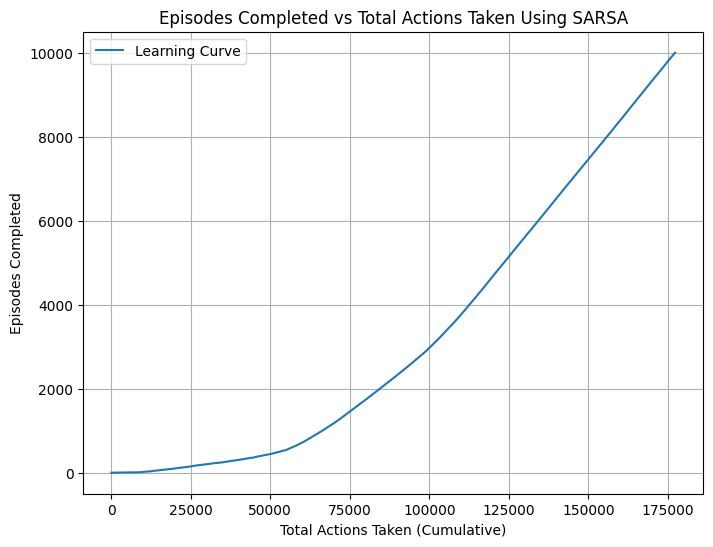

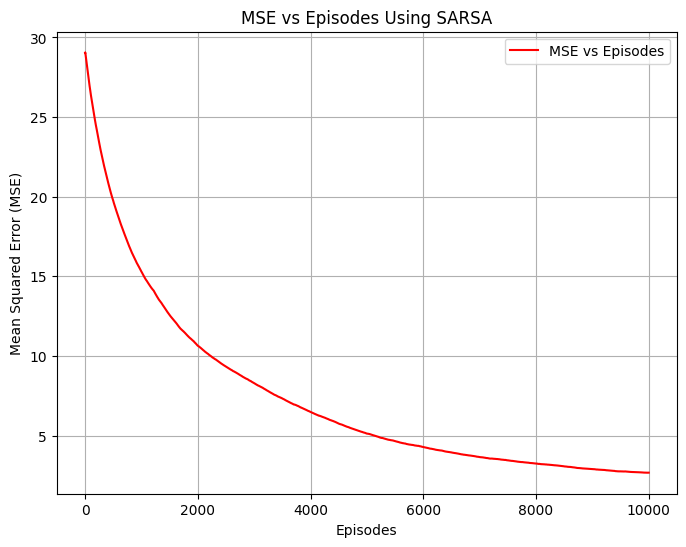

GREEDY POLICY USING SARSA:
→ ↓ ← ↓ᴹ →
→ → → → ↓
↑ X X X ↓
↑ ↑ X → ↓
← →ᴹ → ↑ G


In [14]:
plot_combined_learning_curves_sarsa()

In [ ]:
def q_learning():
    total_runs_actions_list = []
    total_runs_mse_list = []
    final_q = None  # To store Q-values from the last run

    for _ in range(RUNS):
        q, policy = initialize_q_and_policy()
        action_count = 0
        total_actions_list = []
        mse_list = []

        for iter in range(1, MAX_ITERATIONS + 1):
            state = random_initial_state()
            action_probs = policy[state]
            action_index = np.random.choice(len(ACTIONS), p=list(action_probs.values()))
            action = ACTIONS[action_index]
            p = {'specified': 0.7, 'right': 0.12, 'left': 0.12, 'sleepy': 0.06}

            while state != FOOD_STATE:
                transitions = getTransitionProbabilities(action, p)
                moves, probs = zip(*transitions)
                chosen_index = np.random.choice(len(moves), p=probs)
                move = moves[chosen_index]
                next_state = (state[0] + move[0], state[1] + move[1])
                if not is_valid_state(*next_state):
                    next_state = state

                reward = getReward(next_state)
                if next_state == FOOD_STATE:
                    next_action = None
                else:
                    next_action_probs = policy[next_state]
                    next_action_index = np.random.choice(len(ACTIONS), p=list(next_action_probs.values()))
                    next_action = ACTIONS[next_action_index]

                # Update Q-value using max of Q(s', a')
                max_q_next_state = max(q[next_state].values())
                target = reward + GAMMA * max_q_next_state
                q[state][action] += ALPHA * (target - q[state][action])

                state, action = next_state, next_action
                action_count += 1

            # Update policy after the episode
            policy = update_policy(q)

            # Track total actions
            total_actions_list.append(action_count)

            # Compute MSE for the current policy
            v_hat = {
                state: max(q[state].values())  # Use max Q-value to get v̂(s)
                for state in q.keys()
            }
            mse = np.mean([
                (v_hat[state] - value_iteration_v[state[0], state[1]]) ** 2
                for state in v_hat
            ])
            mse_list.append(mse)

        total_runs_actions_list.append(total_actions_list)
        total_runs_mse_list.append(mse_list)
        final_q = q

    # Derive the greedy policy
    greedy_policy = {state: max(final_q[state], key=final_q[state].get) for state in final_q.keys()}
    return total_runs_actions_list, total_runs_mse_list, greedy_policy


In [16]:
def plot_combined_learning_curves_q_learn():
    total_runs_actions_list, total_runs_mse_list, greedy_policy = q_learning()
    
    # Cumulative actions plot
    cumulative_actions_mean = np.mean(total_runs_actions_list, axis=0)
    plt.figure(figsize=(8, 6))
    plt.plot(cumulative_actions_mean, range(1, MAX_ITERATIONS + 1), label="Learning Curve")
    plt.xlabel("Total Actions Taken (Cumulative)")
    plt.ylabel("Episodes Completed")
    plt.title("Episodes Completed vs Total Actions Taken Using Q-learning")
    plt.grid(True)
    plt.legend()
    plt.show()

    # MSE plot
    mse_mean = np.mean(total_runs_mse_list, axis=0)
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, MAX_ITERATIONS + 1), mse_mean, label="MSE vs Episodes", color="red")
    plt.xlabel("Episodes")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title("MSE vs Episodes Using Q-learning")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Convert policy dict to a matrix
    policy_mat = [[None for _ in range(GRID_SIZE)] for _ in range(GRID_SIZE)]
    for (i, j), action in greedy_policy.items():
        policy_mat[i][j] = action
    print("GREEDY POLICY USING Q-LEARNING:")
    printPolicyMat(policy_mat)


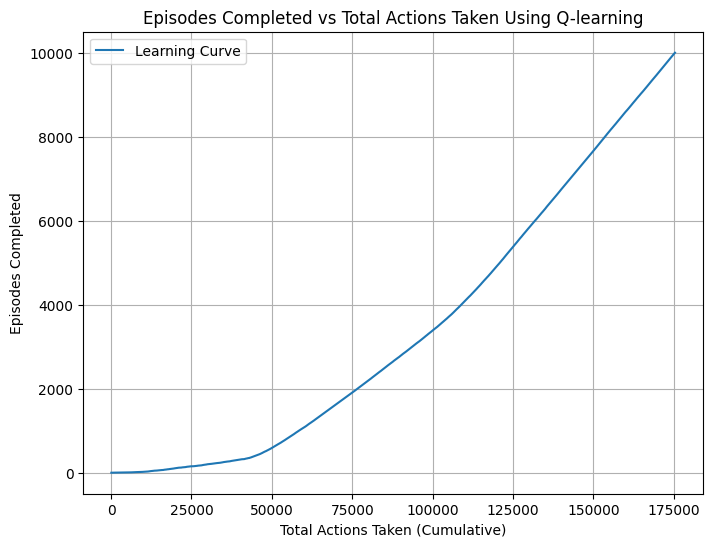

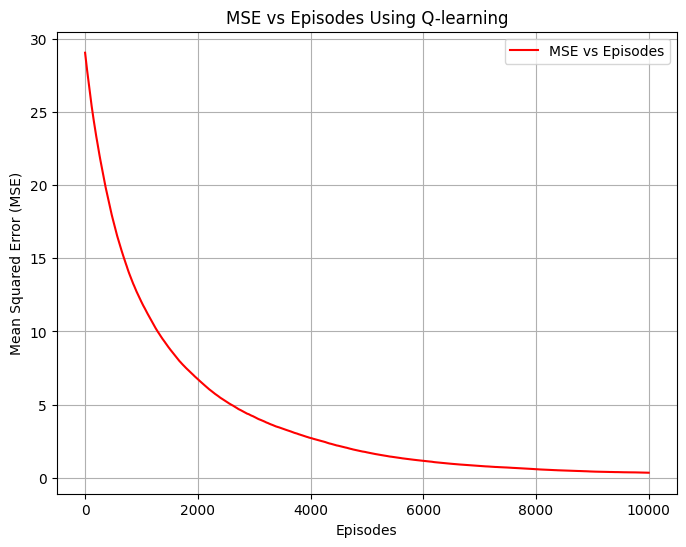

GREEDY POLICY USING Q-LEARNING:
→ ↓ ← ↓ᴹ →
→ → → → ↓
↑ X X X ↓
↑ ↑ X ↓ ↓
← ↑ᴹ → → G


In [17]:
plot_combined_learning_curves_q_learn()